# Hydrodynamic Simulations

## Result
To run the simulations, the following shell script was used, and it's standard out redirected to `lab8.log`.
It was run in the `pyro2` directory.

```sh
#!/bin/bash

set -o errexit -o nounset -o noclobber -o pipefail

setSetting() {
    FILE="$1"
    SETTING="$2"
    VALUE="$3"

    sed -Ei 's/^('"$SETTING"'[[:space:]]*=[[:space:]]*)[0-9.]+/\1'"$VALUE"'/m' "$FILE"
}

# Disable outputting live simulation results in a window
setSetting "_defaults" "dovis" 0
sed -i 's/ plt.show()/ #plt.show()/' analysis/plotvar.py

rm -f *.h5

# Advection simulations
for SOLVER in advection advection_rk; do
    for INPUT in smooth tophat; do
        for LIMITER in 0 1 2; do
            for CFL in $(seq 0.1 0.01 1.5); do
                OUT_DIR="../output/$SOLVER-$INPUT-$LIMITER-$CFL"
                if [ -d "$OUT_DIR" ]; then
                    continue
                fi
                mkdir -p "$OUT_DIR"

                echo -n "($SOLVER, $INPUT, $LIMITER, $CFL): "
                setSetting "$SOLVER/problems/inputs.$INPUT" "cfl" "$CFL"
                setSetting "$SOLVER/problems/inputs.$INPUT" "limiter" "$LIMITER"

                ./pyro.py "$SOLVER" "$INPUT" "inputs.$INPUT" > "$OUT_DIR/log" 2>&1
                mv *.h5 "$OUT_DIR/"

                OUTPUTS=("$OUT_DIR"/*.h5)
                analysis/smooth_error.py "${OUTPUTS[-1]}" |& grep error | awk '{print $6}'
                analysis/plotvar.py "${OUTPUTS[-1]}" density -o "$OUT_DIR/out.png"
            done
        done
    done
done

# Diffusion simulations
setSetting "diffusion/problems/inputs.gaussian" "dt_out" "0.00001"
for K in 0.5 1.0 1.5; do
    OUT_DIR="../output/diffusion-gaussian-$K"
    rm -rf "$OUT_DIR"
    mkdir -p "$OUT_DIR"

    setSetting "diffusion/problems/inputs.gaussian" "k" "$K"
    ./pyro.py diffusion gaussian inputs.gaussian > "$OUT_DIR/log" 2>&1
    mv *.h5 "$OUT_DIR/"
done

# Blast wave simulations
setSetting "compressible/problems/inputs.sedov" "dt_out" "0.00001"
for LIMITER in 0 1 2; do
    for CVISC in 0.001 0.1 10; do
        OUT_DIR="../output/blast-$LIMITER-$CVISC"
        rm -rf "$OUT_DIR"
        mkdir -p "$OUT_DIR"

        setSetting "compressible/problems/inputs.sedov" "limiter" "$LIMITER"
        setSetting "compressible/problems/inputs.sedov" "cvisc" "$CVISC"
        ./pyro.py compressible sedov inputs.sedov > "$OUT_DIR/log" 2>&1
        mv *.h5 "$OUT_DIR/"
    done
done
```

### Errors in `advection` solver
With the (smooth, tophat), limiter = (0, 1, 2), cfl = (0.1 .. 1.5) parameters, we get the following relative error plots:

(Note: The output is scrollable)

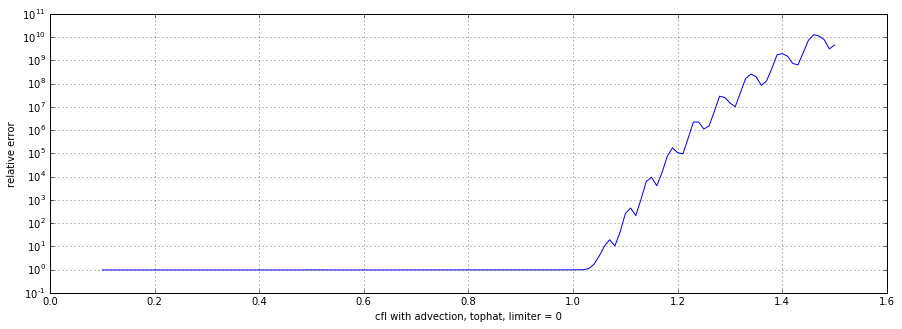

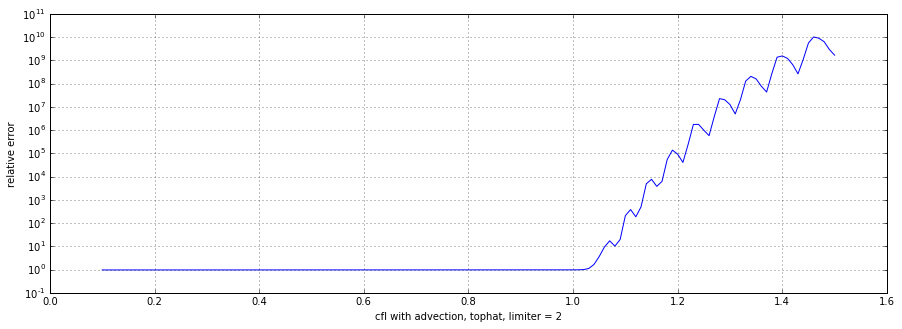

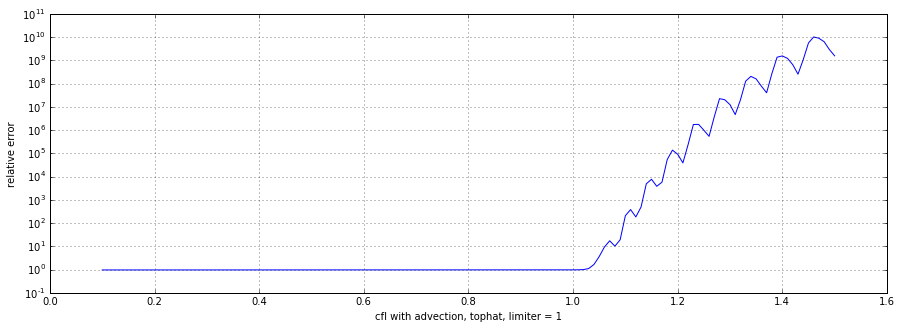

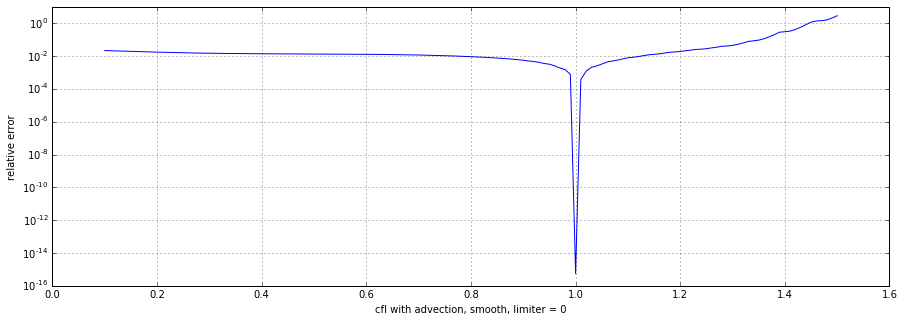

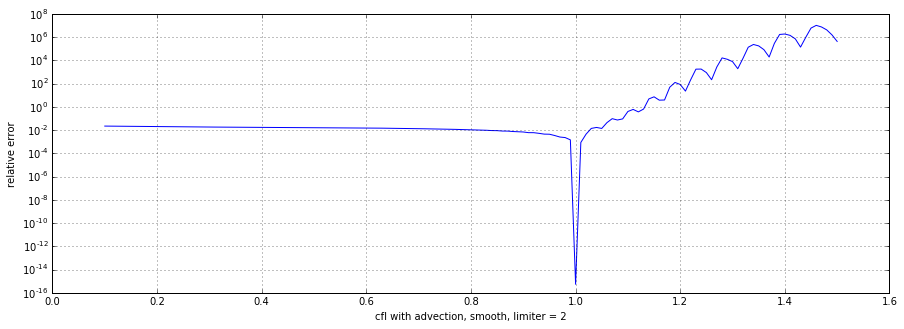

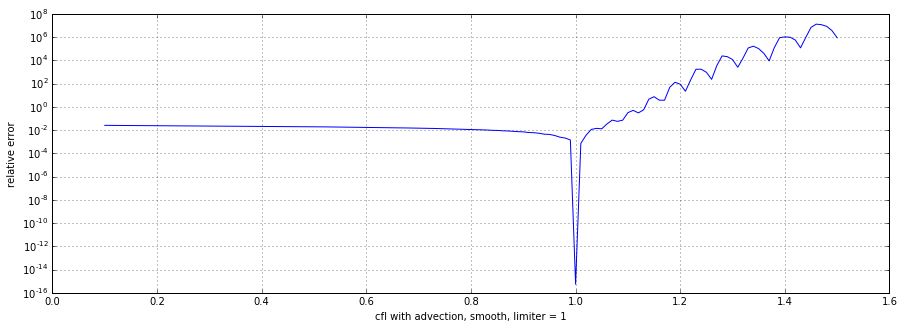

In [1]:
import matplotlib.pyplot as plot
import re

plot.rcParams["figure.figsize"] = (15, 5)

data = dict()
for line in open("lab8.log").read().split("\n"):
    match = re.match("\(([^,]+), ([^,]+), ([^,]+), ([^,]+)\): (.*)", line)
    if not match:
        continue
    sim = match.group(1)
    inputs = match.group(2)
    limit = match.group(3)
    cfl = float(match.group(4))
    error = float(match.group(5))
    
    if not (sim in data):
        data[sim] = dict()
    if not (inputs in data[sim]):
        data[sim][inputs] = dict()
    if not (limit in data[sim][inputs]):
        data[sim][inputs][limit] = {"cfl":[], "error":[]}
    data[sim][inputs][limit]["cfl"].append(cfl)
    data[sim][inputs][limit]["error"].append(error)
    
sim = "advection"
simData = data[sim]
for inputs, inputsData in simData.items():
    for limit, limitsData in inputsData.items():
        plot.semilogy(limitsData["cfl"], limitsData["error"])
        plot.xlabel("cfl with {}, {}, limiter = {}".format(sim, inputs, limit))
        plot.ylabel("relative error")
        plot.grid()
        plot.show()

### Errors in `advection_rk` solver
Same as above, but using `advection_rk` instead

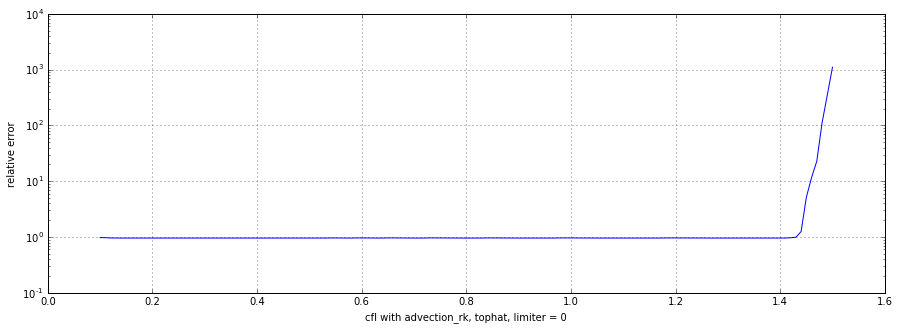

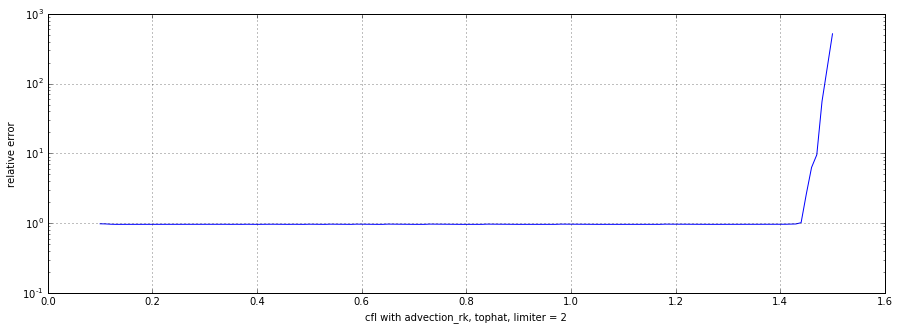

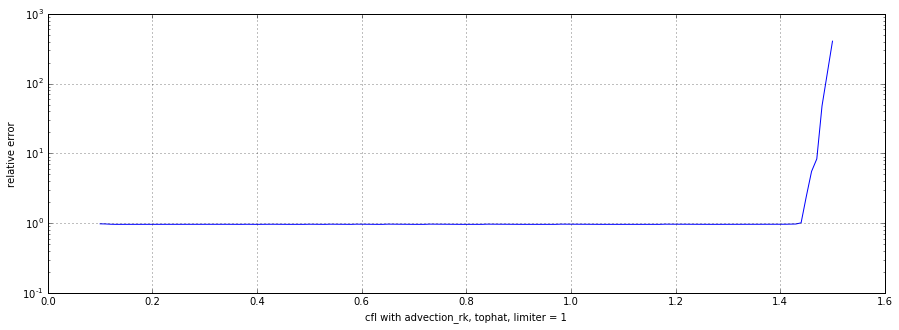

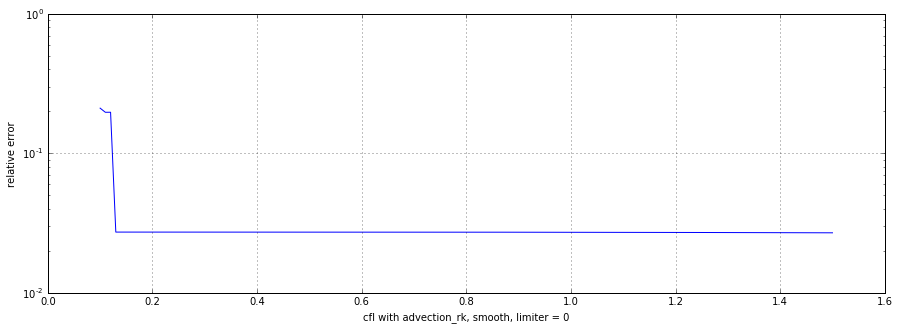

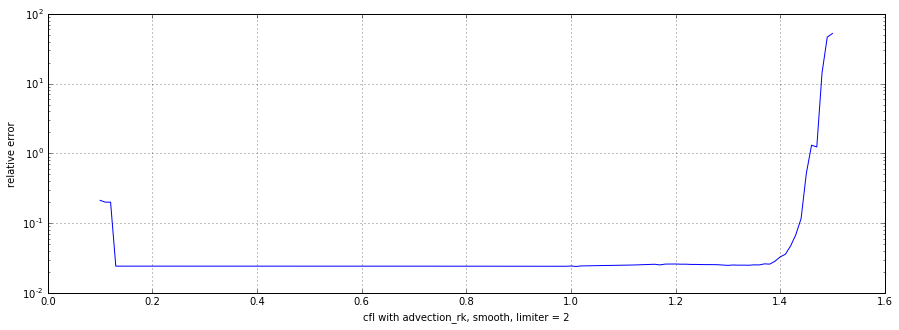

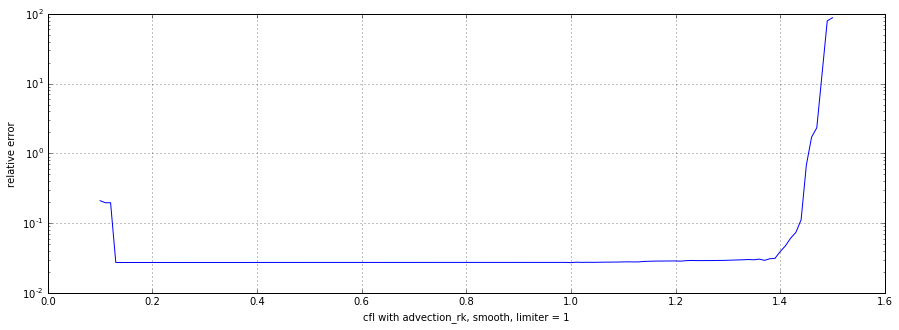

In [2]:
sim = "advection_rk"
simData = data[sim]
for inputs, inputsData in simData.items():
    for limit, limitsData in inputsData.items():
        plot.semilogy(limitsData["cfl"], limitsData["error"])
        plot.xlabel("cfl with {}, {}, limiter = {}".format(sim, inputs, limit))
        plot.ylabel("relative error")
        plot.grid()
        plot.show()

Meanwhile, the simulation results for (smooth, tophat) and limit = (0, 2) where cfl is set to 0.8 looks like:

smooth, limiter = 0


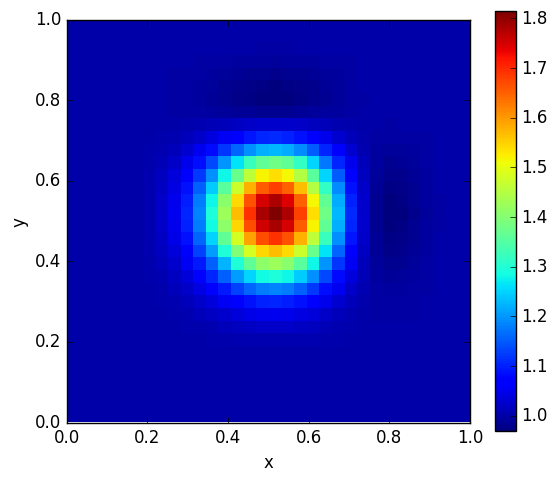

smooth, limiter = 2


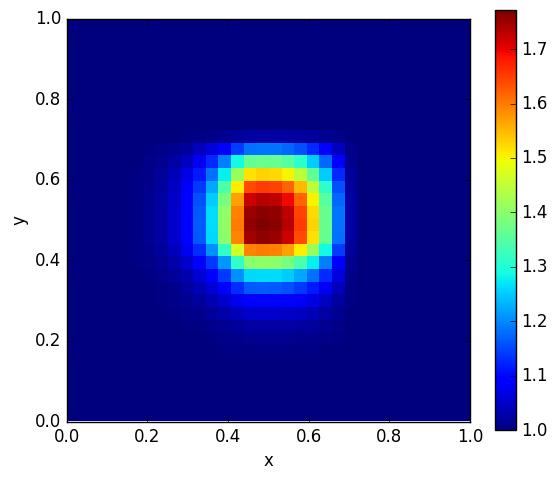

tophat, limiter = 0


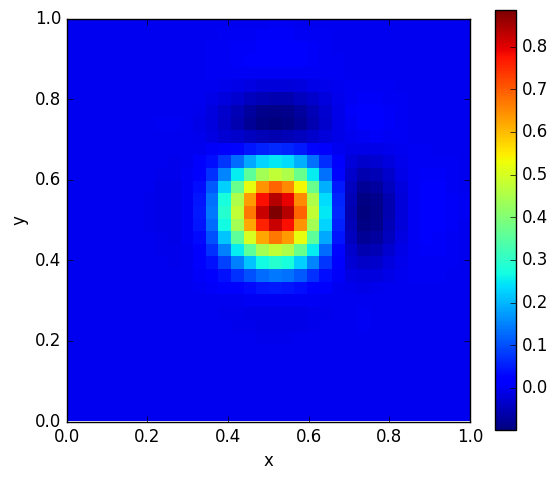

tophat, limiter = 2


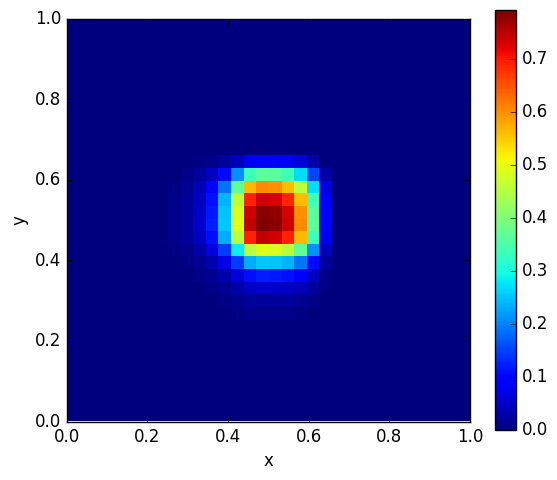

In [3]:
import IPython.display
for inputs in ("smooth", "tophat"):
    for limit in ("0", "2"):
        print("{}, limiter = {}".format(inputs, limit))
        IPython.display.display(IPython.display.Image("output/advection_rk-{}-{}-0.80/out.png".format(inputs, limit)))

### `diffusion` solver
For the different values of k = (0.5, 1.0, 1.5), we get the following results (animated!)

In [4]:
import glob
import numpy
import matplotlib.animation, matplotlib.image, matplotlib.pyplot

from util import io as pyro2io

plot.rcParams["figure.figsize"] = (5, 5)

def makeAnimation(experiment):
    images = []
    for snapshot in glob.glob(experiment + "/*.h5"):
        data = pyro2io.read(snapshot)
        images.append(numpy.transpose(data.cc_data.get_var("phi").v()))

    flattenedImage = [numpy.max(value) for row in images for value in row]
        
    fig = matplotlib.pyplot.figure()
    image = matplotlib.pyplot.imshow(images[0], origin = "lower", animated = True, vmin = numpy.nanmin(flattenedImage), vmax = numpy.nanmax(flattenedImage))

    def updateFrame(frame):
        image.set_array(images[frame])
        return image,

    return matplotlib.animation.FuncAnimation(fig, updateFrame, frames = len(images), interval = 20, blit = True)

for experiment in glob.glob("output/diffusion-gaussian-*"):
    print("k = {}".format(experiment.split("-")[-1]))
    IPython.display.display(IPython.display.HTML(makeAnimation(experiment).to_html5_video()))

k = 0.5


k = 1.0


k = 1.5


### `compessible` solver on `inputs.sedov`
For the different values of limiter = (0, 1, 2) and cvisc = (0.001, 0.1, 10), we get the following results (animated again!)

In [5]:
def makeAnimation(experiment):
    images = []
    for snapshot in glob.glob(experiment + "/*.h5"):
        data = pyro2io.read(snapshot)
        images.append(numpy.transpose(data.cc_data.get_var("density").v()))

    flattenedImage = [numpy.max(value) for row in images for value in row]
        
    fig = matplotlib.pyplot.figure()
    image = matplotlib.pyplot.imshow(images[0], origin = "lower", animated = True, vmin = numpy.nanmin(flattenedImage), vmax = numpy.nanmax(flattenedImage))

    def updateFrame(frame):
        image.set_array(images[frame])
        return image,

    return matplotlib.animation.FuncAnimation(fig, updateFrame, frames = len(images), interval = 100, blit = True)

for experiment in glob.glob("output/blast-*"):
    parts = experiment.split("-")
    print("limiter = {}, cvisc = {}".format(parts[-2], parts[-1]))
    IPython.display.display(IPython.display.HTML(makeAnimation(experiment).to_html5_video()))

limiter = 0, cvisc = 0.001


limiter = 0, cvisc = 0.1


limiter = 0, cvisc = 10


limiter = 1, cvisc = 0.001


limiter = 1, cvisc = 0.1


limiter = 1, cvisc = 10


limiter = 2, cvisc = 0.001


limiter = 2, cvisc = 0.1


limiter = 2, cvisc = 10


## Discussion
### Advection simulation errors
For the `advection` solver, relative errors stay at around 2% and 100% for the smooth and tophat inputs, respectively, for low cfl values, before increasing exponentially for values of cfl > 1 (excluding the smooth, limiter = 0 case). This indicates the `advection` solver is relatively fine for the smooth input for cfl values less than 1, while it is horrible for the tophat input.

Interestingly, the smooth input has a very small (almost 0) error when cfl is equal to 1.00, which could indicate that the solver can provide very high accuracy for tuned values of cfl.

Meanwhile, with the `advection_rk` solver, relative errors stayed at around 3% and 100% (smooth and tophat, respectively) for low cfl values, and only increasing exponentially once cfl increased above 1.4 (excluding the smooth, limiter = 0 case). Ths indicates that while `advection_rk` is less accurate than `advection`, one can use larger cfl values, which might lead to a faster simulation.

For the tophat inputs, varying the limiter didn't seem to change the errors, while for the smooth input, reduced the error for large values of cfl significantly (and in fact stayed at 3% for `advection_rk`).

Since both solvers gave errors of 100% or worse for the tophat input, it could indicate our error checker `analysis/smooth_error.py` might not be designed for the tophat input, and only works on the smooth input.

Visually examining the result of the solver shows there *is* a difference between turning the limiter on or off, despite `analysis/smooth_error.py` saying the errors are the same between the two. This could indicate `analysis/smooth_error.py` is treating the limiter value as a environment parameter, rather than a simulation parameter.

### Diffusion simulations
For low values of k, the gaussian quickly dissipates, while for larger values of k, it dissipates much more slowly.

How is this illustrated in my results? Well, just watch the animation and compare how long the diffusion takes in each one.

If we think of diffusion as heat conductivity, this would make k correspond to the inverse of the heat conductivity of the medium.

### Blast wave simulations
For values of cvisc = (0.001, 0.1, 10), the blast wave moves slower for larger cvisc values, though for large values of cvsic or with the limiter off, the simulation results are clipping, so this may not be a valid result.

If we turn on the limiter, we no longer get clipping for cvisc = (0.001, 0.1), and get a nice blast wave in the result. But since we've turned the limiter on (to prevent values shooting off past the maximum value), it might mean our results are no longer as accurate as it could, but at least it means we get *some* result rather than a clipped mess.